In [8]:
import cv2  # for image processing
import numpy as np  # for matrix operations
import torch  # for deep learning
import matplotlib.pyplot as plt  # for visualization

%matplotlib inline

lidar2cam = np.array([[0, 1, 0, 0],
             [0, 0, -1, 0.0508],
             [-1, 0, 0, 0.0502],
             [0, 0, 0, 1]])

lidar2ground = np.array([[0.9753423,  0.0000000,  0.2206974, 0],
                [0.0000000,  1.0000000,  0.0000000, 0],
                [-0.2206974,  0.0000000,  0.9753423, 12],
                [0, 0, 0, 1]])

l2c_rot = lidar2cam[:3, :3]
c2l_rot = l2c_rot.T
l2g_rot = lidar2ground[:3, :3]



In [13]:
# Load the image, the intrinsic and extrinsic matrices
# change this to the path of your image
image = cv2.imread(
    "/home/adrian/dev/metrics/dec7_daytime_2/related_images/000240_pcd/000240.jpg")
K = np.array([[1199.821557, 0.000000, 960.562236], [
             0.000000, 1198.033465, 551.675808], [0.000000, 0.000000, 1.000000]])
R = c2l_rot @ l2g_rot
# t = np.array([0, 0, 0]) # change this to your extrinsic translation vector

# Compute the homography matrix
H = K @ R @ np.linalg.inv(K)
H

array([[     0.2207,    -0.80178,     -939.91],
       [    0.97389,    -0.46048,     -417.04],
       [          0,  -0.0008347,     0.46048]])

In [3]:
# Load the yolov5n model and detect objects in the image
# load the model from https://github.com/ultralytics/yolov5
model = torch.hub.load('ultralytics/yolov5', 'yolov5n')
results = model(image)  # run inference on the image
results.print()  # print the results

# Get the bounding boxes and labels of the detected objects
# get the bounding boxes in xyxy format (x1, y1, x2, y2)
boxes = results.xyxy[0].cpu().numpy()
labels = results.names  # get the labels of the detected classes

Using cache found in /home/adrian/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-8 Python-3.8.18 torch-1.10.1+cu111 CUDA:0 (NVIDIA T1200 Laptop GPU, 3912MiB)



  0%|          | 0.00/3.87M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients, 4.5 GFLOPs
Adding AutoShape... 
image 1/1: 1080x1920 9 cars, 1 bus, 3 trucks, 1 boat
Speed: 1.4ms pre-process, 26.7ms inference, 1.2ms NMS per image at shape (1, 3, 384, 640)


In [4]:
# Project the bounding boxes to the ground plane in 3D
boxes_3d = []
for box in boxes:
    # Get the four corners of the box in homogeneous coordinates
    p1 = np.array([box[0], box[1], 1])
    p2 = np.array([box[2], box[1], 1])
    p3 = np.array([box[2], box[3], 1])
    p4 = np.array([box[0], box[3], 1])

    # Apply the homography matrix to get the corresponding points in the ground plane
    q1 = H @ p1
    q2 = H @ p2
    q3 = H @ p3
    q4 = H @ p4

    # Normalize by the third coordinate to get cartesian coordinates
    q1 = q1 / q1[2]
    q2 = q2 / q2[2]
    q3 = q3 / q3[2]
    q4 = q4 / q4[2]

    # Append the four points to the list of boxes in 3D
    boxes_3d.append([q1, q2, q3, q4])

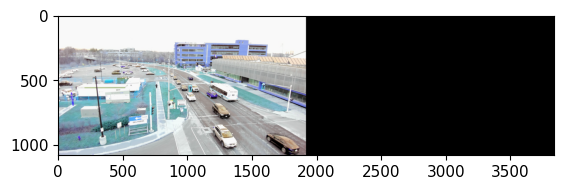

In [12]:
# Apply the homography transformation to the image
img_warped = cv2.warpPerspective(image, H, (image.shape[1], image.shape[0]))

img_concat = np.hstack((image, img_warped))

plt.imshow(image)
plt.imshow(img_concat)
plt.show()